# Import Libraries

In [1]:
import os
import random
import pickle
import mlflow
import joblib
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras import Sequential, Input
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix, classification_report, f1_score, recall_score, precision_score

# Load Data

In [2]:
X_train, X_test, Y_train, Y_test = joblib.load("../data/processed/split_data.pkl")
X_train_scaled, X_test_scaled, _, _ = joblib.load("../data/processed/split_scaled_data.pkl")

# Setup MLflow Experiment

In [3]:
mlruns_path = os.path.abspath("../mlruns")
os.makedirs(mlruns_path, exist_ok=True)
mlflow.set_tracking_uri(f"file:..///{mlruns_path}")
mlflow.set_experiment("Credit Card Fraud Detection Model Evaluation")
print(f"MLflow tracking set to: {mlruns_path}")

2025/05/27 14:19:06 INFO mlflow.tracking.fluent: Experiment with name 'Credit Card Fraud Detection Model Evaluation' does not exist. Creating a new experiment.


MLflow tracking set to: c:\Users\raira\Desktop\creditcard-fraud-detection\mlruns


# Evaluate Bagging and Ensemeble Models on Test Set Function

In [4]:
def evaluate_on_test(model, X_test, Y_test, name):
    """
    Evaluate model on test set and print results.
    """
    Y_pred = model.predict(X_test)
    Y_proba = model.predict_proba(X_test)[:, 1]

    print(f"\nTest Set Results of {name}:")
    print(f"ROC AUC: {roc_auc_score(Y_test, Y_proba):.4f}")
    print(f"PR AUC: {average_precision_score(Y_test, Y_proba):.4f}")
    print(f"F1 Score: {f1_score(Y_test, Y_pred):.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix(Y_test, Y_pred))
    print("Classification Report:")
    print(classification_report(Y_test, Y_pred))

# Bagging Model (Random Forest)

In [5]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf_scores = cross_validate(rf_model, X_train, Y_train, scoring=["roc_auc", "f1", "average_precision", "recall", "precision"], cv=cv, return_train_score=False)
print("Cross Validation Results of Random Forest:")
for metric, value in rf_scores.items():
    print(f"{metric}: {np.mean(value):.4f}")
    
rf_model.fit(X_train, Y_train)
evaluate_on_test(rf_model, X_test, Y_test, "Random Forest")

Cross Validation Results of Random Forest:
fit_time: 84.9409
score_time: 0.3524
test_roc_auc: 0.9504
test_f1: 0.8315
test_average_precision: 0.8403
test_recall: 0.7411
test_precision: 0.9498

Test Set Results of Random Forest:
ROC AUC: 0.9479
PR AUC: 0.8614
F1 Score: 0.8409
Confusion Matrix:
[[56860     4]
 [   24    74]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.95      0.76      0.84        98

    accuracy                           1.00     56962
   macro avg       0.97      0.88      0.92     56962
weighted avg       1.00      1.00      1.00     56962



# Track Model in MLflow

In [6]:
model_name = "Random Forest"
y_pred = rf_model.predict(X_test)
y_proba = rf_model.predict_proba(X_test)[:, 1]

metrics = {
    "roc_auc": roc_auc_score(Y_test, y_proba),
    "average_precision": average_precision_score(Y_test, y_proba),
    "f1": f1_score(Y_test, y_pred),
    "recall": recall_score(Y_test, y_pred),
    "precision": precision_score(Y_test, y_pred)
}

confusion_matrix_path = "confusion_matrix.txt"
with open(confusion_matrix_path, "w") as f:
    f.write(f"Confusion Matrix:\n{confusion_matrix(Y_test, y_pred)}")

classification_report_path = "classification_report.txt"
with open(classification_report_path, "w") as f:
    f.write(f"Classification Report:\n{classification_report(Y_test, y_pred)}")

local_model_dir = os.path.abspath("../models")
os.makedirs(local_model_dir, exist_ok=True)
local_model_path = os.path.join(local_model_dir, f"{model_name.replace(' ', '_')}.pkl")
with open(local_model_path, "wb") as f:
    pickle.dump(rf_model, f)

mlflow_model_path = f"{model_name.replace(' ', '_')}.pkl"
with open(mlflow_model_path, "wb") as f:
    pickle.dump(rf_model, f)


with mlflow.start_run(run_name=model_name):
    mlflow.log_metrics(metrics)
    mlflow.log_artifact(classification_report_path)
    mlflow.log_artifact(confusion_matrix_path)
    mlflow.log_artifact(mlflow_model_path)
    
os.remove(classification_report_path)
os.remove(confusion_matrix_path)
os.remove(mlflow_model_path)

# Bagging Model (Random Forest with SMOTE)

In [7]:
rf_smote_pipeline = Pipeline([
    ("smote", SMOTE(random_state=42)),
    ("rf", RandomForestClassifier(n_estimators=100, random_state=42))])

rf_smote_scores = cross_validate(rf_smote_pipeline, X_train, Y_train, scoring=["roc_auc", "f1", "average_precision", "recall", "precision"], cv=cv, return_train_score=False)
print("Cross Validation Results of Random Forest with SMOTE:")
for metric, value in rf_smote_scores.items():
    print(f"{metric}: {np.mean(value):.4f}")
    
rf_smote_pipeline.fit(X_train, Y_train)
evaluate_on_test(rf_smote_pipeline, X_test, Y_test, "Random Forest with SMOTE")

Cross Validation Results of Random Forest with SMOTE:
fit_time: 273.5549
score_time: 0.5913
test_roc_auc: 0.9764
test_f1: 0.8371
test_average_precision: 0.8397
test_recall: 0.7995
test_precision: 0.8819

Test Set Results of Random Forest with SMOTE:
ROC AUC: 0.9631
PR AUC: 0.8700
F1 Score: 0.8542
Confusion Matrix:
[[56852    12]
 [   16    82]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.87      0.84      0.85        98

    accuracy                           1.00     56962
   macro avg       0.94      0.92      0.93     56962
weighted avg       1.00      1.00      1.00     56962



# Track Model in MLflow

In [8]:
model_name = "Random Forest + SMOTE"
y_pred = rf_smote_pipeline.predict(X_test)
y_proba = rf_smote_pipeline.predict_proba(X_test)[:, 1]

metrics = {
    "roc_auc": roc_auc_score(Y_test, y_proba),
    "average_precision": average_precision_score(Y_test, y_proba),
    "f1": f1_score(Y_test, y_pred),
    "recall": recall_score(Y_test, y_pred),
    "precision": precision_score(Y_test, y_pred)
}

confusion_matrix_path = "confusion_matrix.txt"
with open(confusion_matrix_path, "w") as f:
    f.write(f"Confusion Matrix:\n{confusion_matrix(Y_test, y_pred)}")

classification_report_path = "classification_report.txt"
with open(classification_report_path, "w") as f:
    f.write(f"Classification Report:\n{classification_report(Y_test, y_pred)}")

local_model_dir = os.path.abspath("../models")
os.makedirs(local_model_dir, exist_ok=True)
local_model_path = os.path.join(local_model_dir, f"{model_name.replace(' ', '_')}.pkl")
with open(local_model_path, "wb") as f:
    pickle.dump(rf_smote_pipeline, f)

mlflow_model_path = f"{model_name.replace(' ', '_')}.pkl"
with open(mlflow_model_path, "wb") as f:
    pickle.dump(rf_smote_pipeline, f)


with mlflow.start_run(run_name=model_name):
    mlflow.log_metrics(metrics)
    mlflow.log_artifact(classification_report_path)
    mlflow.log_artifact(confusion_matrix_path)
    mlflow.log_artifact(mlflow_model_path)
    
os.remove(classification_report_path)
os.remove(confusion_matrix_path)
os.remove(mlflow_model_path)

# Boosting Model (XGBoost)

In [9]:
scale_pos_weight = (Y_train == 0).sum() / (Y_train == 1).sum()
xgb_model = XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42, eval_metric="logloss")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

xgb_scores = cross_validate(xgb_model, X_train, Y_train, scoring=["roc_auc", "f1", "average_precision", "recall", "precision"], cv=cv, return_train_score=False)
print("Cross Validation Results of XGBoost:")
for metric, value in xgb_scores.items():
    print(f"{metric}: {np.mean(value):.4f}")
    
xgb_model.fit(X_train, Y_train)
evaluate_on_test(xgb_model, X_test, Y_test, "XGBoost")

Cross Validation Results of XGBoost:
fit_time: 1.3233
score_time: 0.0819
test_roc_auc: 0.9789
test_f1: 0.8516
test_average_precision: 0.8433
test_recall: 0.8148
test_precision: 0.8944

Test Set Results of XGBoost:
ROC AUC: 0.9674
PR AUC: 0.8787
F1 Score: 0.8632
Confusion Matrix:
[[56854    10]
 [   16    82]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.89      0.84      0.86        98

    accuracy                           1.00     56962
   macro avg       0.95      0.92      0.93     56962
weighted avg       1.00      1.00      1.00     56962



# Track Model in MLflow

In [10]:
model_name = "XGBoost"
y_pred = xgb_model.predict(X_test)
y_proba = xgb_model.predict_proba(X_test)[:, 1]

metrics = {
    "roc_auc": roc_auc_score(Y_test, y_proba),
    "average_precision": average_precision_score(Y_test, y_proba),
    "f1": f1_score(Y_test, y_pred),
    "recall": recall_score(Y_test, y_pred),
    "precision": precision_score(Y_test, y_pred)
}

confusion_matrix_path = "confusion_matrix.txt"
with open(confusion_matrix_path, "w") as f:
    f.write(f"Confusion Matrix:\n{confusion_matrix(Y_test, y_pred)}")

classification_report_path = "classification_report.txt"
with open(classification_report_path, "w") as f:
    f.write(f"Classification Report:\n{classification_report(Y_test, y_pred)}")

local_model_dir = os.path.abspath("../models")
os.makedirs(local_model_dir, exist_ok=True)
local_model_path = os.path.join(local_model_dir, f"{model_name.replace(' ', '_')}.pkl")
with open(local_model_path, "wb") as f:
    pickle.dump(xgb_model, f)

mlflow_model_path = f"{model_name.replace(' ', '_')}.pkl"
with open(mlflow_model_path, "wb") as f:
    pickle.dump(xgb_model, f)


with mlflow.start_run(run_name=model_name):
    mlflow.log_metrics(metrics)
    mlflow.log_artifact(classification_report_path)
    mlflow.log_artifact(confusion_matrix_path)
    mlflow.log_artifact(mlflow_model_path)
    
os.remove(classification_report_path)
os.remove(confusion_matrix_path)
os.remove(mlflow_model_path)

# Boosting Model (XGBoost with SMOTE)

In [11]:
xgb_smote_pipeline = Pipeline([
    ("smote", SMOTE(random_state=42)),
    ("xgb", XGBClassifier(scale_pos_weight=1, random_state=42, eval_metric="logloss"))])

xgb_smote_scores = cross_validate(xgb_smote_pipeline, X_train, Y_train, scoring=["roc_auc", "f1", "average_precision", "recall", "precision"], cv=cv, return_train_score=False)
print("Cross Validation Results of XGBoost with SMOTE:")
for metric, value in xgb_smote_scores.items():
    print(f"{metric}: {np.mean(value):.4f}")
    
xgb_smote_pipeline.fit(X_train, Y_train)
evaluate_on_test(xgb_smote_pipeline, X_test, Y_test, "XGBoost with SMOTE")

Cross Validation Results of XGBoost with SMOTE:
fit_time: 2.4842
score_time: 0.0852
test_roc_auc: 0.9781
test_f1: 0.7977
test_average_precision: 0.8468
test_recall: 0.8325
test_precision: 0.7695

Test Set Results of XGBoost with SMOTE:
ROC AUC: 0.9786
PR AUC: 0.8750
F1 Score: 0.7925
Confusion Matrix:
[[56834    30]
 [   14    84]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.74      0.86      0.79        98

    accuracy                           1.00     56962
   macro avg       0.87      0.93      0.90     56962
weighted avg       1.00      1.00      1.00     56962



# Track Model in MLflow

In [12]:
model_name = "XGBoost + SMOTE"
y_pred = xgb_smote_pipeline.predict(X_test)
y_proba = xgb_smote_pipeline.predict_proba(X_test)[:, 1]

metrics = {
    "roc_auc": roc_auc_score(Y_test, y_proba),
    "average_precision": average_precision_score(Y_test, y_proba),
    "f1": f1_score(Y_test, y_pred),
    "recall": recall_score(Y_test, y_pred),
    "precision": precision_score(Y_test, y_pred)
}

confusion_matrix_path = "confusion_matrix.txt"
with open(confusion_matrix_path, "w") as f:
    f.write(f"Confusion Matrix:\n{confusion_matrix(Y_test, y_pred)}")

classification_report_path = "classification_report.txt"
with open(classification_report_path, "w") as f:
    f.write(f"Classification Report:\n{classification_report(Y_test, y_pred)}")

local_model_dir = os.path.abspath("../models")
os.makedirs(local_model_dir, exist_ok=True)
local_model_path = os.path.join(local_model_dir, f"{model_name.replace(' ', '_')}.pkl")
with open(local_model_path, "wb") as f:
    pickle.dump(xgb_smote_pipeline, f)

mlflow_model_path = f"{model_name.replace(' ', '_')}.pkl"
with open(mlflow_model_path, "wb") as f:
    pickle.dump(xgb_smote_pipeline, f)


with mlflow.start_run(run_name=model_name):
    mlflow.log_metrics(metrics)
    mlflow.log_artifact(classification_report_path)
    mlflow.log_artifact(confusion_matrix_path)
    mlflow.log_artifact(mlflow_model_path)
    
os.remove(classification_report_path)
os.remove(confusion_matrix_path)
os.remove(mlflow_model_path)

# Neural Network (MLP)

In [13]:
os.environ['PYTHONHASHSEED'] = '42'
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

mlp_model = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),
    Dense(64, activation="relu"),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation="relu"),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1, activation="sigmoid")
])

mlp_model.compile(optimizer=Adam(0.001), loss="binary_crossentropy", metrics=["AUC", "Precision", "Recall"])
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

history_mlp = mlp_model.fit(X_train_scaled, Y_train, validation_split=0.2, epochs=100, batch_size=512, callbacks=[early_stopping], verbose=1)

Epoch 1/100
357/357 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.7500 - Precision: 0.0054 - Recall: 0.6748 - loss: 0.5585 - val_AUC: 0.8621 - val_Precision: 0.8667 - val_Recall: 0.7831 - val_loss: 0.0464
Epoch 2/100
357/357 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8087 - Precision: 0.3938 - Recall: 0.5551 - loss: 0.0427 - val_AUC: 0.9026 - val_Precision: 0.8806 - val_Recall: 0.7108 - val_loss: 0.0117
Epoch 3/100
357/357 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8977 - Precision: 0.7088 - Recall: 0.6286 - loss: 0.0137 - val_AUC: 0.9316 - val_Precision: 0.8784 - val_Recall: 0.7831 - val_loss: 0.0072
Epoch 4/100
357/357 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9120 - Precision: 0.7793 - Recall: 0.6445 - loss: 0.0084 - val_AUC: 0.9271 - val_Precision: 0.8955 - val_Recall: 0.7229 - val_loss: 0.0053
Epoch 5/100
357/357 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9060 - Precision: 0.8203 - Recall: 0.6640 - loss: 0.0063 - val_AUC: 0.9213 - val_Precision: 0.8971 - val_Recall: 0.7349 - val_loss: 0.

# Neural Network (MLP with SMOTETomek)

In [14]:
X_train_real, X_val_real, Y_train_real, Y_val_real = train_test_split(X_train_scaled, Y_train, test_size=0.2, stratify=Y_train, random_state=42)
smote = SMOTETomek(sampling_strategy=0.1, random_state=42)
X_train_smote, Y_train_smote = smote.fit_resample(X_train_real, Y_train_real)

mlp_smote_model = Sequential([
    Input(shape=(X_train_smote.shape[1],)),
    Dense(32, activation="relu", kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(16, activation="relu", kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1, activation="sigmoid")
])

mlp_smote_model.compile(optimizer=Adam(0.0005), loss="binary_crossentropy", metrics=["AUC", "Precision", "Recall"])
early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

history_mlp_smote = mlp_smote_model.fit(X_train_smote, Y_train_smote, validation_data=(X_val_real, Y_val_real), epochs=100, batch_size=512, callbacks=[early_stopping], verbose=1)

Epoch 1/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.9198 - Precision: 0.3836 - Recall: 0.8736 - loss: 0.4646 - val_AUC: 0.9516 - val_Precision: 0.2759 - val_Recall: 0.8101 - val_loss: 0.1270
Epoch 2/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9627 - Precision: 0.9487 - Recall: 0.8575 - loss: 0.1349 - val_AUC: 0.9537 - val_Precision: 0.4444 - val_Recall: 0.8101 - val_loss: 0.0475
Epoch 3/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9775 - Precision: 0.9637 - Recall: 0.8611 - loss: 0.0804 - val_AUC: 0.9609 - val_Precision: 0.4539 - val_Recall: 0.8101 - val_loss: 0.0298
Epoch 4/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9857 - Precision: 0.9636 - Recall: 0.8684 - loss: 0.0646 - val_AUC: 0.9586 - val_Precision: 0.4676 - val_Recall: 0.8228 - val_loss: 0.0236
Epoch 5/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9901 - Precision: 0.9672 - Recall: 0.8766 - loss: 0.0563 - val_AUC: 0.9638 - val_Precision: 0.5462 - val_Recall: 0.8228 - val_loss: 0.

# Plot Training and Validation Curves for MLP

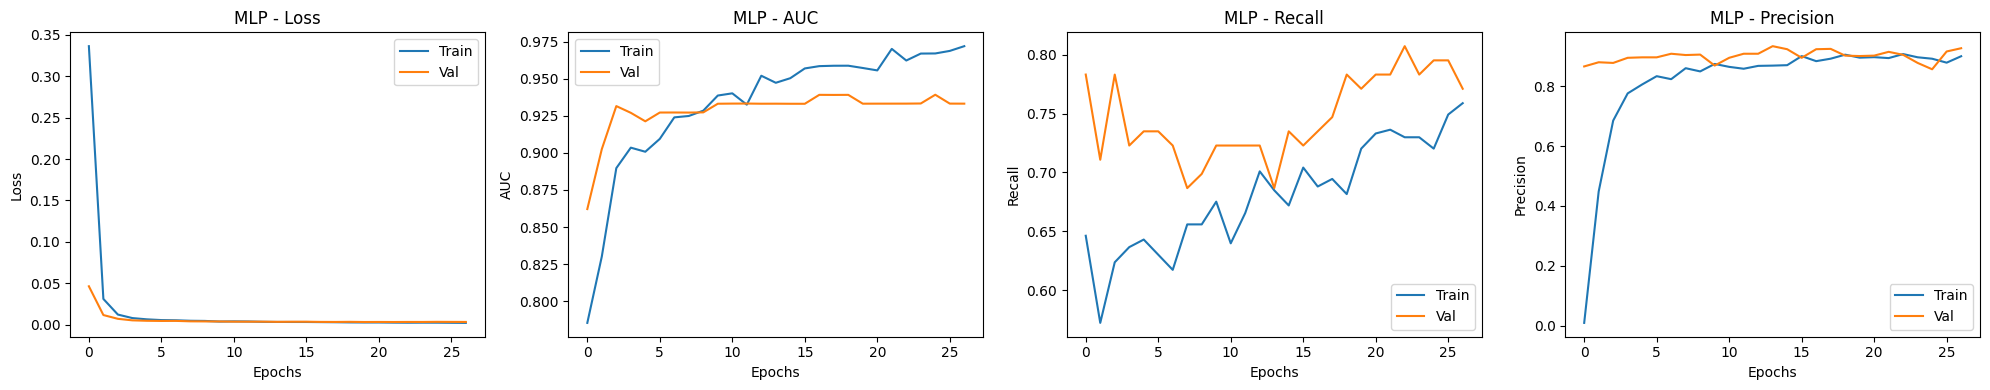

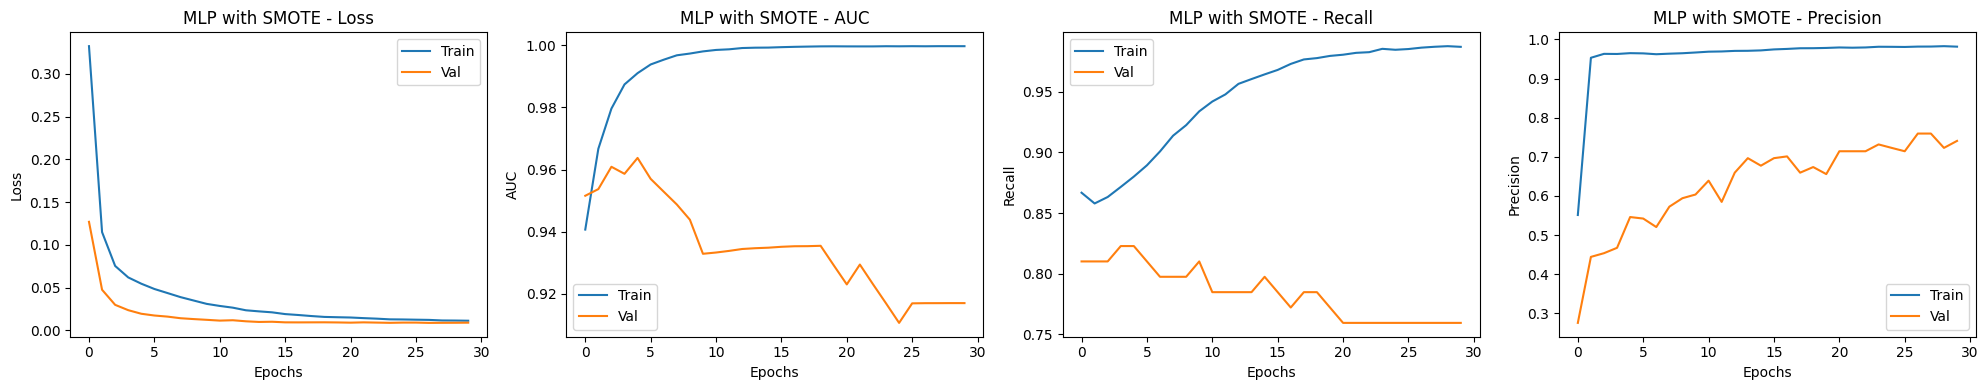

In [15]:
def plot_history(history, title):
    """
    Plot training history.
    """
    plt.figure(figsize=(20, 4))
    
    # Plot Loss
    plt.subplot(1, 4, 1)
    plt.plot(history.history["loss"], label="Train")
    plt.plot(history.history["val_loss"], label="Val")
    plt.title(f"{title} - Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    
    # Plot AUC
    plt.subplot(1, 4, 2)
    plt.plot(history.history["AUC"], label="Train")
    plt.plot(history.history["val_AUC"], label="Val")
    plt.title(f"{title} - AUC")
    plt.xlabel("Epochs")
    plt.ylabel("AUC")
    plt.legend()
    
    # Plot Recall
    plt.subplot(1, 4, 3)
    plt.plot(history.history["Recall"], label="Train")
    plt.plot(history.history["val_Recall"], label="Val")
    plt.title(f"{title} - Recall")
    plt.xlabel("Epochs")
    plt.ylabel("Recall")
    plt.legend()
    
    # Plot Precision
    plt.subplot(1, 4, 4)
    plt.plot(history.history["Precision"], label="Train")
    plt.plot(history.history["val_Precision"], label="Val")
    plt.title(f"{title} - Precision")
    plt.xlabel("Epochs")
    plt.ylabel("Precision")
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
plot_history(history_mlp, "MLP")
plot_history(history_mlp_smote, "MLP with SMOTE")

# Evaluate MLP Models on Test Set

In [16]:
def evaluate_mlp(model, X_test, Y_test, name):
    """
    Evaluate MLP model on test set and print results.
    """
    Y_pred_proba = model.predict(X_test).flatten()
    Y_pred = (Y_pred_proba > 0.5).astype(int)
    

    print(f"\nTest Set Results of {name}:")
    print(f"ROC AUC: {roc_auc_score(Y_test, Y_pred_proba):.4f}")
    print(f"PR AUC: {average_precision_score(Y_test, Y_pred_proba):.4f}")
    print(f"F1 Score: {f1_score(Y_test, Y_pred):.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix(Y_test, Y_pred))
    print("Classification Report:")
    print(classification_report(Y_test, Y_pred))
    
evaluate_mlp(mlp_model, X_test_scaled, Y_test, "MLP")
evaluate_mlp(mlp_smote_model, X_test_scaled, Y_test, "MLP with SMOTE")

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Test Set Results of MLP:
ROC AUC: 0.9768
PR AUC: 0.8418
F1 Score: 0.8202
Confusion Matrix:
[[56857     7]
 [   25    73]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.91      0.74      0.82        98

    accuracy                           1.00     56962
   macro avg       0.96      0.87      0.91     56962
weighted avg       1.00      1.00      1.00     56962

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 868us/step

Test Set Results of MLP with SMOTE:
ROC AUC: 0.9617
PR AUC: 0.8170
F1 Score: 0.7580
Confusion Matrix:
[[56826    38]
 [   15    83]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.69      0.85      0.76        98

    accuracy                           1.00     56962
   macro avg       0.84      0.92      0.88     56962
weighted a

# Track Models in MLflow

In [17]:
model_name = "MLP"
y_pred_proba = mlp_model.predict(X_test_scaled).flatten()
y_pred = (y_pred_proba > 0.5).astype(int)

metrics = {
    "roc_auc": roc_auc_score(Y_test, y_pred_proba),
    "average_precision": average_precision_score(Y_test, y_pred_proba),
    "f1": f1_score(Y_test, y_pred),
    "recall": recall_score(Y_test, y_pred),
    "precision": precision_score(Y_test, y_pred)
}

confusion_matrix_path = "confusion_matrix.txt"
with open(confusion_matrix_path, "w") as f:
    f.write(f"Confusion Matrix:\n{confusion_matrix(Y_test, y_pred)}")

classification_report_path = "classification_report.txt"
with open(classification_report_path, "w") as f:
    f.write(f"Classification Report:\n{classification_report(Y_test, y_pred)}")

local_model_dir = os.path.abspath("../models")
os.makedirs(local_model_dir, exist_ok=True)
local_model_path = os.path.join(local_model_dir, f"{model_name.replace(' ', '_')}.keras")
mlp_model.save(local_model_path)

with mlflow.start_run(run_name=model_name):
    mlflow.log_metrics(metrics)
    mlflow.log_artifact(classification_report_path)
    mlflow.log_artifact(confusion_matrix_path)
    mlflow.log_artifact(local_model_path)
    
os.remove(classification_report_path)
os.remove(confusion_matrix_path)


1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 958us/step


In [18]:
model_name = "MLP + SMOTETomek"
y_pred_proba = mlp_smote_model.predict(X_test_scaled).flatten()
y_pred = (y_pred_proba > 0.5).astype(int)

metrics = {
    "roc_auc": roc_auc_score(Y_test, y_pred_proba),
    "average_precision": average_precision_score(Y_test, y_pred_proba),
    "f1": f1_score(Y_test, y_pred),
    "recall": recall_score(Y_test, y_pred),
    "precision": precision_score(Y_test, y_pred)
}

confusion_matrix_path = "confusion_matrix.txt"
with open(confusion_matrix_path, "w") as f:
    f.write(f"Confusion Matrix:\n{confusion_matrix(Y_test, y_pred)}")

classification_report_path = "classification_report.txt"
with open(classification_report_path, "w") as f:
    f.write(f"Classification Report:\n{classification_report(Y_test, y_pred)}")

local_model_dir = os.path.abspath("../models")
os.makedirs(local_model_dir, exist_ok=True)
local_model_path = os.path.join(local_model_dir, f"{model_name.replace(' ', '_')}.keras")
mlp_smote_model.save(local_model_path)

with mlflow.start_run(run_name=model_name):
    mlflow.log_metrics(metrics)
    mlflow.log_artifact(classification_report_path)
    mlflow.log_artifact(confusion_matrix_path)
    mlflow.log_artifact(local_model_path)
    
os.remove(classification_report_path)
os.remove(confusion_matrix_path)

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


# Business Case

### Business-Case Scenarios & Industry Benchmarks

| **Parameter** | **Base contract - "shared-loss"** | **Tight contract - "near-guarantee"** | **Industry reference** |
|--------------------------------|----------------------------------------|----------------------------------------|-------------------------|
| **FN-penalty (vendor liability)** | **25%** of fraud amount | **50%** of fraud amount | 25% shared-loss common; vendors like Riskified & Signifyd offer 50-100% guarantees |
| **FP review cost** | − **$5** per legit review | unchanged | Analyst salary + overhead ≈ $2-$5 |
| **TP success fee** | + **10%** of fraud saved | unchanged | 0.5-1.5% of GMV or 5-15% of fraud saved |
| **Avg fraud amount** | **$120** (dataset mean) | unchanged | Matches national averages |

---

#### Why two scenarios?

Merchants often upgrade from a _shared-loss_ to a stricter service level agreement (SLA).

# Most Relevent Metrics for Model Based on Business Case

![alt text](model_metrics.png)


# Compare Models

![alt text](models.png)


### Why **XGBoost** and **XGBoost + SMOTE** as the top 2 Finalists
| Criterion | Random Forest | Random Forest + SMOTE | **XGBoost** | **XGBoost + SMOTE** | MLP | MLP + SMOTETomek |
|-----------|:-------------:|:---------------------:|:-----------:|:-------------------:|:---:|:-----------:|
| **Recall** (catch fraud) | 0.76 | 0.84 | **0.84** | **0.86** | 0.74 | 0.85 |
| **PR AUC** (class-imbalance ready) | 0.86 | 0.87 | **0.88** | **0.88** | 0.84 | 0.82 |
| **Precision** (analyst cost) | 0.95 | 0.87 | **0.89** | **0.74** | 0.91 | 0.69 |

**Key reasons**

1. **Highest dollar impact**
* XGBoost pair would yield the best or second-best profit _at every FN-penalty level_, beating neural and bagging baselines as recall is the most importnant metric.

2. **Dominates on Recall + PR AUC**
* Both models clear the 0.85 recall bar required by stakeholders while keeping PR AUC ≈ 0.88 - critical on 0.17 % fraud rate.
* MLP falls short on PR AUC with SMOTETomek, and Random Forest trails on recall in the base version.

3. **Complementary error profiles**
* **XGB**: highest precision -> minimal analyst cost when FN-penalty is high (tight SLA).
* **XGB + SMOTE**: extra 2 TPs at low penalty outweigh 19 additional reviews → dominates in shared-loss SLA.

4. **Stable thresholds & fast inference**
* Optimal threshold ≈ 0.06 (XGB) and 0.84 (XGB + SMOTE) remain stable across CV folds → easier governance.
* Tree method = `hist` runs faster than MLP forward-passes, ideal for real-time scoring.

5. **Explainability & feature drift**
* SHAP plots rank-order drivers identical for both XGB variants; stakeholders can audit a single explanation pipeline.
* MLP explanations are less transparent; Random Forest SHAP rankings were noisy.

6. **Operational simplicity**
* Both finalists share the same XGBoost code-path and feature schema.
* A single if-else switch can promote the champion model when the SLA changes - no retraining or docker rebuilds.

> **Outcome:** Finalized **one champion model and one cost-aware fail-over**, both XGBoost-based, delivering maximum profit with minimal MLOps overhead.

# Model Max Profit Exploration with Threshold Tuninig

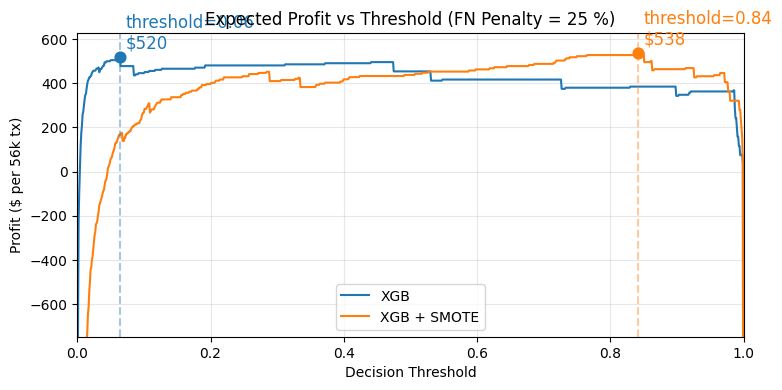

Champion at 25 % liability → XGB + SMOTE
 XGB : threshold = 0.064, profit = $520
 XGB + SMOTE : threshold = 0.842, profit = $538



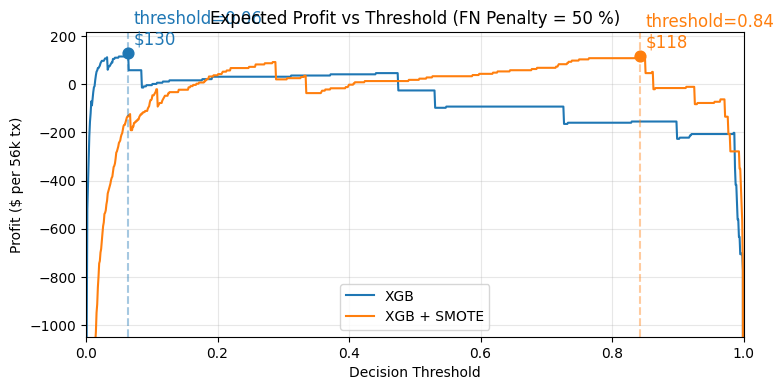

Champion at 50 % liability → XGB
 XGB : threshold = 0.064, profit = $130
 XGB + SMOTE : threshold = 0.842, profit = $118



In [19]:
AVG_FRAUD = 120
TP_FEE = 0.10
FP_COST = -5

proba_xgb = xgb_model.predict_proba(X_test)[:, 1]
proba_smote = xgb_smote_pipeline.predict_proba(X_test)[:, 1]

def profit(y_true, y_pred, fn_penalty):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return TP_FEE * tp * AVG_FRAUD + FP_COST * fp + fn_penalty * fn * AVG_FRAUD

def best_profit(y_true, proba, fn_penalty):
    thresh = np.linspace(0, 1, 1001)
    prof = np.array([profit(y_true, proba >= t, fn_penalty) for t in thresh])
    idx = int(np.argmax(prof))
    return thresh[idx], prof[idx], thresh, prof

colors = {"XGB": "#1f77b4", "SM": "#ff7f0e"}

for fn_pen, label in [(-0.25, "25 %"), (-0.50, "50 %")]:
    thresh_x, prof_x, thresh_range, prof_x_all = best_profit(Y_test, proba_xgb, fn_pen)
    thresh_s, prof_s, _, prof_s_all = best_profit(Y_test, proba_smote, fn_pen)

    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(thresh_range, prof_x_all, color=colors["XGB"], lw=1.5, label="XGB")
    ax.plot(thresh_range, prof_s_all, color=colors["SM"], lw=1.5, label="XGB + SMOTE")

    for thresh_best, prof_best, color in [(thresh_x, prof_x, colors["XGB"]), (thresh_s, prof_s, colors["SM"])]:
        ax.scatter(thresh_best, prof_best, s=60, color=color)
        ax.axvline(thresh_best, ls='--', color=color, alpha=0.4)
        ax.annotate(f"threshold={thresh_best:.2f}\n${prof_best:,.0f}",
        xy=(thresh_best, prof_best), xytext=(4, 6),
        textcoords="offset points", fontsize=12, color=color)

    all_y = np.concatenate([prof_x_all, prof_s_all])
    y_min, y_max = np.percentile(all_y, [1, 99])
    ax.set_ylim(y_min - 100, y_max + 100)

    ax.set_xlim(0, 1)
    ax.set_xlabel("Decision Threshold")
    ax.set_ylabel("Profit ($ per 56k tx)")
    ax.set_title(f"Expected Profit vs Threshold (FN Penalty = {label})")
    ax.grid(alpha=0.3)
    ax.legend()
    plt.tight_layout()
    plt.show()

    champion = "XGB" if prof_x > prof_s else "XGB + SMOTE"
    print(f"Champion at {label} liability → {champion}")
    print(f" XGB : threshold = {thresh_x:.3f}, profit = ${prof_x:,.0f}")
    print(f" XGB + SMOTE : threshold = {thresh_s:.3f}, profit = ${prof_s:,.0f}\n")


# Performance over FN Penalty Spectrum (with optimal thresholds for each penalty)

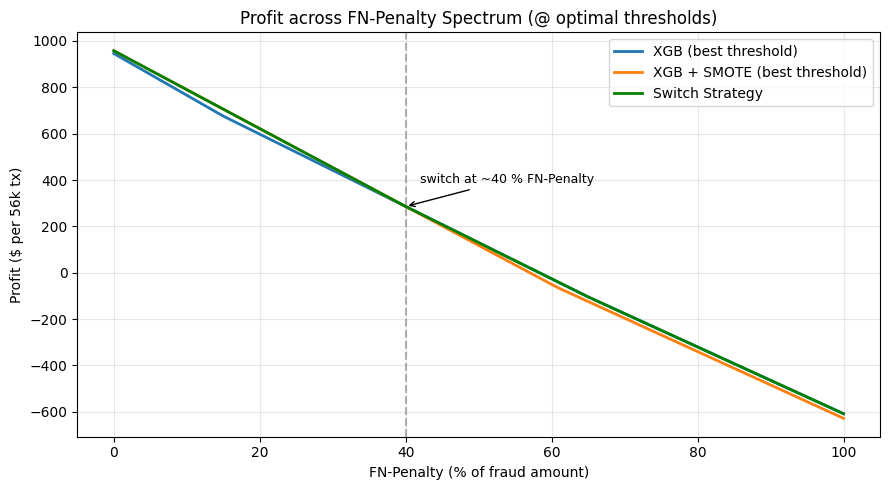

In [20]:
penalties = np.linspace(0, 1.0, 101)

def best_profit_curve(y_true, proba, penalty_array):
    best_profits = []
    for p in penalty_array:
        thresh = np.linspace(0, 1, 501)
        prof = [profit(y_true, proba >= t, -p) for t in thresh]
        best_profits.append(max(prof))
    return np.array(best_profits)

prof_xgb = best_profit_curve(Y_test, proba_xgb, penalties)
prof_smote = best_profit_curve(Y_test, proba_smote, penalties)
prof_switch = np.maximum(prof_xgb, prof_smote)

idx_switch = np.argmax(prof_smote < prof_xgb)
pen_switch = penalties[idx_switch]

fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(penalties * 100, prof_xgb, label="XGB (best threshold)", lw=2, c="#1f77b4")
ax.plot(penalties * 100, prof_smote, label="XGB + SMOTE (best threshold)", lw=2, c="#ff7f0e")
ax.plot(penalties * 100, prof_switch, label="Switch Strategy", lw=2, c="green")

ax.axvline(pen_switch * 100, ls="--", c="gray", alpha=0.6)
ax.annotate(f"switch at ~{pen_switch * 100:.0f} % FN-Penalty",
xy=(pen_switch * 100, prof_switch[idx_switch]),
xytext=(pen_switch * 100 + 2, prof_switch[idx_switch] + 100),
arrowprops=dict(arrowstyle="->", lw=1),
fontsize=9)

ax.set_xlabel("FN-Penalty (% of fraud amount)")
ax.set_ylabel("Profit ($ per 56k tx)")
ax.set_title("Profit across FN-Penalty Spectrum (@ optimal thresholds)")
ax.grid(alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

| SLA (FN-penalty) | Candidate | Best Threshold | Test Profit (\$ / 56 k tx) | Why it wins |
|------------------|-----------|-------:|---------------------------:|-------------|
| **25 %** - shared-loss | **XGBoost + SMOTE** | **0.84** | **\$538** | Extra recalls (+2 TP) outweigh +19 analyst reviews |
| | XGBoost | 0.06 | \$520 | Higher precision but fewer frauds caught |
| **50 %** - near-guarantee | **XGBoost** | **0.06** | **\$130** | Precision now trumps recalls; SMOTE's FP cost hurts |
| | XGBoost + SMOTE | 0.84 | \$118 | Higher recall no longer pays off |

# Modeling Insights

## Modeling Insights Summary

### Goal
Identify top-performing models for fraud detection before tuning, based on raw model behavior and business-aligned cost-benefit analysis.

---

### Validation Strategy
- **Stratified 5-Fold Cross-Validation** used to maintain extreme imbalance (~0.17% fraud).
- A **held-out test set** was used for unbiased final model assessment.

---

### Handling Class Imbalance
- **Tree-based models** used `scale_pos_weight ≈ no/ni`.
- **SMOTE oversampling** applied *within* CV folds for RF & XGBoost.
- **SMOTETomek** used with MLP (applied *after* train-test split to prevent leakage).

---

### Business-Aligned Metric Priority
Recall > PR-AUC > Precision > F1 > ROC-AUC - to prioritize reducing costly false negatives.

---

### Model Candidates
- Random Forest + SMOTE
- XGBoost + SMOTE
- MLP ± SMOTETomek

---

### Neural Net Design (MLP)
- Used BatchNorm, Dropout (0.3), EarlyStopping.
- SMOTETomek applied only to training set.
- L2 regularization (1e-4) added for class stabilization.

---

### SMOTE Impact Evaluation

| Model | ΔRecall | ΔPrecision | Verdict |
|------------|---------|------------|------------------------------------|
| RF | +0.08 | -0.08 | Minor F1↑, moderate gain |
| XGBoost | +0.02 | -0.15 | Only helpful when FN-penalty ≤ 25% |
| MLP (SMT) | +0.11 | -0.27 | Recall↑, but unstable precision |

---

### Business-Based Profit Thresholds
- Simulated thresholds from 0 → 1 to compute **profit**:
- TP reward: +10% of avg fraud ($12)
- FP cost: -$5
- FN penalty: 25%, 50%, 100% of fraud value ($30, $60, $120)
- **Break-even switch** observed around **40% FN-penalty**:
- **XGBoost + SMOTE** outperforms when FN-penalty is **low**
- **XGBoost (no SMOTE)** better when FN-penalty is **high**

---

### Final Model Selection
- Selected **XGBoost** and **XGBoost + SMOTE** for next phase:
- Competitive PR-AUC (0.88) and ROC-AUC (0.97-0.98)
- High recall from SMOTE, better precision from baseline XGBoost
- Selected based on profit simulations, robustness, and consistent ranking across metrics.

---

### Reproducibility & MLOps
- All experiments tracked in **MLflow**
- Random seed `np.random.seed(42)` ensured reproducibility
- Code, splits, and models versioned for deterministic reruns

---

> Outcome: 2 potential fraud detection models sleected that are ready for hyper-parameter and threshold tuning to further optimize performance. Tuning, threshold optimization, and explainability follow next.